## Problem Overview
- Predict which Housing Projects would win the next round of California's tax-exempt bond allocations via CDLAC (AWARD = yes)
- Not sure how this prediction will be used in the big picture
- Supervised + classification + batch training problem
- Metric to use: Accuracy and precision? (Confusion matrix)
- Assumptions:
  - The next round of predictions will have the same categories, similar level of competition and funding available
- Challenges:
  - Is 90 instances enough to get a good model? Use sktlearn SGDClassifier
  - Small dataset -> risk of overfitting? 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# ensure changes in files are reflected
%load_ext autoreload
%autoreload 2
# Set display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns

In [2]:
df = pd.read_csv("../data/processed/merged_dataset.csv")

In [3]:
df.head()

,APPLICATION NUMBER,"NC POOL SELECTION: HOMELESS, ELI/VLI, MIP",AWARD,PROJECT NAME,CONSTRUCTION TYPE,HOUSING TYPE,CITY,COUNTY,TOTAL UNITS,LOW INCOME UNITS,MARKET RATE UNITS,UNITS FOR HOMELESS,HOMELESS %,AVERAGE TARGETED AFFORDABILITY,TOTAL PROJECT COSTS,BOND REQUEST,ANNUAL FEDERAL CREDIT REQUEST,STATE CREDIT REQUEST,CDLAC POOL,NEW CONSTRUCTION SET ASIDE,BIPOC PRE-QUALIFIED,CTCAC REGION,CDLAC REGION,CDLAC TOTAL POINTS SCORE,PRESERVATION AND OTHER REHAB. PROJECT PRIORITIES (20 PTS),NEW CONSTRUCTION DENSITY & LOCAL INCENTIVES (10 PTS),EXCEEDING MINIMUM INCOME RESTRICTIONS (20 PTS),EXCEEDING MINIMUM RENT RESTRICTIONS (10 PTS),GP & MGMT. CO. EXPERIENCE (10 PTS),HOUSING NEEDS (10 PTS),LEVERAGED SOFT RESOURCES (8 PTS),READINESS TO PROCEED (10 PTS),AFFIRMATIVELY FURTHERING FAIR HOUSING (10 PTS),SERVICE AMENITIES (10 PTS),COST CONTAINMENT (12 PTS),SITE AMENITIES (10 PTS),CDLAC TIE-BREAKER SELF SCORE,CDLAC APPLICANT,CTCAC APPLICANT,GP1 COMPANY,GP1 CONTACT,GP1 PARENT ORGANIZATION,GP2 COMPANY,GP2 CONTACT,GP2 PARENT COMPANY,GP3 COMPANY,GP3 CONTACT,GP3 PARENT COMPANY
0,CA-25-404,none,Yes,TBV Villas at Renaissance,New Construction,Large Family,Richmond,Contra Costa,105,104,0,0,0.0,0.520192,7.974608e+07,39172547.0,3453606,0,New Construction,none,Yes,East Bay Region: Alameda and Contra Costa Coun...,"Bay Area (Alameda, Contra Costa, Marin, San Fr...",120,0,10,20,10,10,10,8,10,10,10,12,10,1.270722,California Municipal Finance Authority,"GUIDING LIGHT INC-SANDIDGE URBAN GROUP, INC Jo...",Sandidge Urban Group,Cherene Sandidge,none,Guiding Light Inc.,Thomas Vaughns,none,none,none,none
1,CA-25-405,none,No,Adda and Paul Safran Senior Housing,Acq and Rehabilitation,Non-Targeted,Venice,Los Angeles,64,63,0,0,0.0,0.492063,4.326484e+07,21300000.0,1624431,0,Preservation,none,No,City of Los Angeles,City of Los Angeles,104,14,0,20,10,10,0,8,10,0,10,12,10,1.258159,City of Los Angeles,APS Venice LP,"Mountain Park Terrace, Inc.",Mary Grace Crisostomo,HumanGood Affordable Housing,none,none,none,none,none,none
2,CA-25-406,none,Yes,10953 Whipple,New Construction,Non-Targeted,Los Angeles,Los Angeles,91,90,0,0,0.0,0.600000,2.704032e+07,13850000.0,1126137,0,New Construction,none,No,City of Los Angeles,City of Los Angeles,119,0,10,20,10,10,10,8,10,9,10,12,10,1.562613,California Municipal Finance Authority,"HVN Development, LLC",HVN 10953 Whipple LLC,Tommy Beadel,"HVN Development, LLC","Affordable Housing Alliance II, Inc. dba Integ...",Anjela Ponce,"Affordable Housing Alliance II, Inc.",none,none,none
3,CA-25-407,none,Yes,5403 Inglewood,New Construction,Non-Targeted,Los Angeles,Los Angeles,46,45,0,0,0.0,0.600000,1.448602e+07,7325000.0,598975,0,New Construction,none,No,City of Los Angeles,City of Los Angeles,119,0,10,20,10,10,10,8,10,9,10,12,10,1.309339,California Municipal Finance Authority,"HVN Development, LLC",HVN 5403 Inglewood LLC,Tommy Beadel,"HVN Development, LLC","Affordable Housing Alliance II, Inc. dba Integ...",Anjela Ponce,"Affordable Housing Alliance II, Inc.",none,none,none
4,CA-25-408,none,No,12432 Moorpark,New Construction,Non-Targeted,Los Angeles,Los Angeles,102,101,0,0,0.0,0.600000,3.478839e+07,17975000.0,1412345,0,New Construction,none,No,City of Los Angeles,City of Los Angeles,119,0,10,20,10,10,10,8,10,9,10,12,10,1.655012,California Municipal Finance Authority,HVN Development LLC,HVN 12432 Moorpark LLC,Tommy Beadel,HVN Development LLC,"Affordable Housing Alliance II, Inc. dba Integ...",Anjela Ponce,"Affordable Housing Alliance II, Inc.",none,none,none


## Preprocessing for training
- Define X_values and y_values
  - 12 columns selected (5 categorical, 7 numeric) to be used as features
  - "AWARD" is used as the label 
- Split into training and testing (75/25)
  - stratified spliting due to class imbalance (40% "Yes" compared to 60% "No")
- Find Correlations
- Data Cleaning
  - OneHotEncoding (convert categorical to numeric)
  - Scale the values

### Define X and y

In [4]:
y_values = df["AWARD"].map({'Yes': 1, 'No': 0})
y_values.head()

0    1
1    0
2    1
3    1
4    0
Name: AWARD, dtype: int64

In [5]:
numeric = ["AVERAGE TARGETED AFFORDABILITY", 'CDLAC TOTAL POINTS SCORE', 'CDLAC TIE-BREAKER SELF SCORE', "TOTAL PROJECT COSTS", "BOND REQUEST", "ANNUAL FEDERAL CREDIT REQUEST", "HOMELESS %"]
cat = ["CONSTRUCTION TYPE", "HOUSING TYPE", "CDLAC POOL", "NEW CONSTRUCTION SET ASIDE", "CDLAC REGION"]
X_values = df[numeric + cat]

In [6]:
X_values.head()

,AVERAGE TARGETED AFFORDABILITY,CDLAC TOTAL POINTS SCORE,CDLAC TIE-BREAKER SELF SCORE,TOTAL PROJECT COSTS,BOND REQUEST,ANNUAL FEDERAL CREDIT REQUEST,HOMELESS %,CONSTRUCTION TYPE,HOUSING TYPE,CDLAC POOL,NEW CONSTRUCTION SET ASIDE,CDLAC REGION
0,0.520192,120,1.270722,7.974608e+07,39172547.0,3453606,0.0,New Construction,Large Family,New Construction,none,"Bay Area (Alameda, Contra Costa, Marin, San Fr..."
1,0.492063,104,1.258159,4.326484e+07,21300000.0,1624431,0.0,Acq and Rehabilitation,Non-Targeted,Preservation,none,City of Los Angeles
2,0.600000,119,1.562613,2.704032e+07,13850000.0,1126137,0.0,New Construction,Non-Targeted,New Construction,none,City of Los Angeles
3,0.600000,119,1.309339,1.448602e+07,7325000.0,598975,0.0,New Construction,Non-Targeted,New Construction,none,City of Los Angeles
4,0.600000,119,1.655012,3.478839e+07,17975000.0,1412345,0.0,New Construction,Non-Targeted,New Construction,none,City of Los Angeles


In [7]:
X_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   AVERAGE TARGETED AFFORDABILITY  91 non-null     float64
 1   CDLAC TOTAL POINTS SCORE        91 non-null     int64  
 2   CDLAC TIE-BREAKER SELF SCORE    91 non-null     float64
 3   TOTAL PROJECT COSTS             91 non-null     float64
 4   BOND REQUEST                    91 non-null     float64
 5   ANNUAL FEDERAL CREDIT REQUEST   91 non-null     int64  
 6   HOMELESS %                      91 non-null     float64
 7   CONSTRUCTION TYPE               91 non-null     object 
 8   HOUSING TYPE                    91 non-null     object 
 9   CDLAC POOL                      91 non-null     object 
 10  NEW CONSTRUCTION SET ASIDE      91 non-null     object 
 11  CDLAC REGION                    91 non-null     object 
dtypes: float64(5), int64(2), object(5)
mem

In [8]:
X_values.shape

(91, 12)

### Split into train and test

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size = 0.25, stratify=y_values, random_state=42)

In [10]:
X_train.shape

(68, 12)

### Finding Correlations
- strong correlation between total project costs, bond request and annual federal credit request (>0.9)
- moderate correlation between homeles % and average targeted affordability (-0.47)

<Axes: >

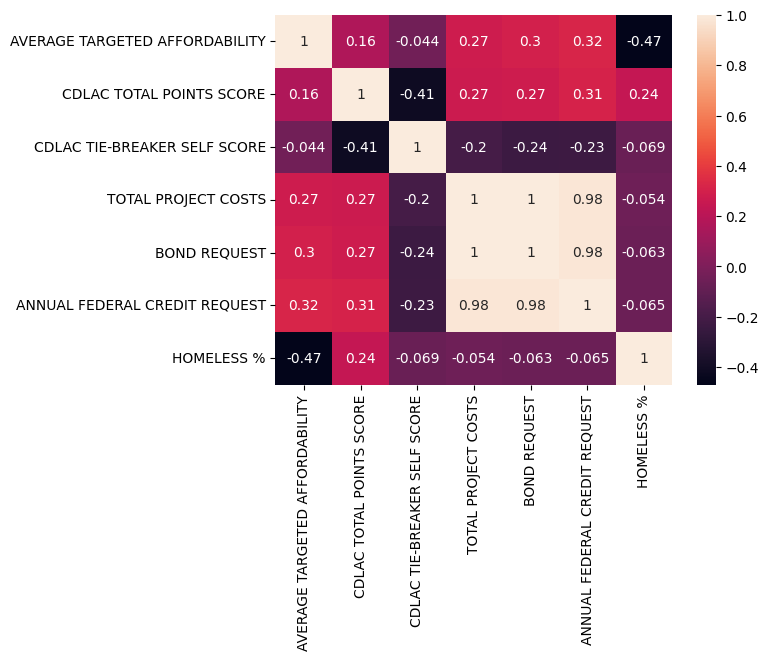

In [25]:
sb.heatmap(X_train[numeric].corr(), annot=True)

array([[<Axes: xlabel='AVERAGE TARGETED AFFORDABILITY', ylabel='AVERAGE TARGETED AFFORDABILITY'>,
        <Axes: xlabel='CDLAC TOTAL POINTS SCORE', ylabel='AVERAGE TARGETED AFFORDABILITY'>,
        <Axes: xlabel='CDLAC TIE-BREAKER SELF SCORE', ylabel='AVERAGE TARGETED AFFORDABILITY'>,
        <Axes: xlabel='TOTAL PROJECT COSTS', ylabel='AVERAGE TARGETED AFFORDABILITY'>,
        <Axes: xlabel='BOND REQUEST', ylabel='AVERAGE TARGETED AFFORDABILITY'>,
        <Axes: xlabel='ANNUAL FEDERAL CREDIT REQUEST', ylabel='AVERAGE TARGETED AFFORDABILITY'>,
        <Axes: xlabel='HOMELESS %', ylabel='AVERAGE TARGETED AFFORDABILITY'>],
       [<Axes: xlabel='AVERAGE TARGETED AFFORDABILITY', ylabel='CDLAC TOTAL POINTS SCORE'>,
        <Axes: xlabel='CDLAC TOTAL POINTS SCORE', ylabel='CDLAC TOTAL POINTS SCORE'>,
        <Axes: xlabel='CDLAC TIE-BREAKER SELF SCORE', ylabel='CDLAC TOTAL POINTS SCORE'>,
        <Axes: xlabel='TOTAL PROJECT COSTS', ylabel='CDLAC TOTAL POINTS SCORE'>,
        <Axes: xlabel=

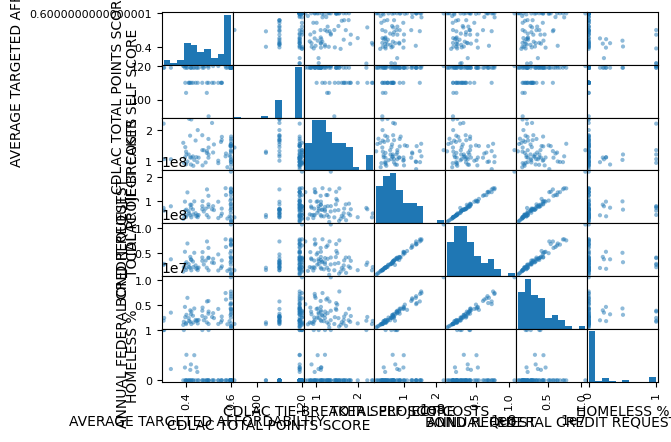

In [12]:
pd.plotting.scatter_matrix(X_train)

In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat)
    ])

# Model pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

## Model training
- RandomForestClassifier??
- metric F1 Score and ROC-AUC??

In [14]:
# Train model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['AVERAGE TARGETED '
                                                   'AFFORDABILITY',
                                                   'CDLAC TOTAL POINTS SCORE',
                                                   'CDLAC TIE-BREAKER SELF '
                                                   'SCORE',
                                                   'TOTAL PROJECT COSTS',
                                                   'BOND REQUEST',
                                                   'ANNUAL FEDERAL CREDIT '
                                                   'REQUEST',
                                                   'HOMELESS %']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['CONSTRUCTION TYPE',
                                                   'HOUSING TYPE', 'CDLAC POOL',
                                                   'NEW CONSTRUCTION SET ASIDE',
                                                   'CDLAC REGION'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [15]:
from sklearn.metrics import classification_report, roc_auc_score
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

ROC-AUC: 0.735


In [16]:
scores = cross_val_score(pipeline, X_values, y_values, cv=5, scoring='f1')
print(f"Cross-validation F1 scores: {scores.mean():.3f} ± {scores.std():.3f}")

Cross-validation F1 scores: 0.503 ± 0.128


In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.77      0.71        13
           1       0.62      0.50      0.56        10

    accuracy                           0.65        23
   macro avg       0.65      0.63      0.63        23
weighted avg       0.65      0.65      0.65        23



## Testing different models